# Config
change name and path of config for dataset, imagenet

In [1]:
from data import data_manager
from config.config_manager import _C as cfg
cfg.DATASET.NAME = "imagenet"
cfg.DATASET.TRAIN_PATH = "/home/allen.jc.lin/imagenet/"

make sure the 
1. ilsvrc2012_train
2. ilsvrc2012_val
3. ILSVRC2012_validation_ground_truth.txt

is under the cfg.DATASET.TRAIN_PATH

# Load ImageNet
there are train and val subsets, each return a list of tuple with image path and label in integer

In [2]:
dataset = get_img_data(cfg)

=> ImageNet loaded
Dataset statistics:
  ------------------------------
  subset   | # class | # images
  ------------------------------
  train    |    1000 |  1281167
  val      |    1000 |    50000
  ------------------------------


# Make LMDB
1. use PIL to load image and turn to byte string
2. tqdm to supervise the progress
3. use caffe datum as the serialized string to make value of LMDB

In [ ]:
#     message Datum {
#       optional int32 channels = 1;
#       optional int32 height = 2;
#       optional int32 width = 3;
#       // the actual image data, in bytes
#       optional bytes data = 4;
#       optional int32 label = 5;
#       // Optionally, the datum could also hold float data.
#       repeated float float_data = 6;
#       // If true data contains an encoded image that need to be decoded
#       optional bool encoded = 7 [default = false];
#     }

# Transform
resize to 256x256 and rgb image

In [12]:
from PIL import Image
import lmdb
from tqdm import tqdm
from data import caffe_pb2
import re
pattern = re.compile(r"(n\d+)/(n\d+_\d+.JPEG)")
train_lmdb_file = '/home/allen.jc.lin/imagenet/imagenet_256x256_lmdb_train2'
val_lmdb_file = '/home/allen.jc.lin/imagenet/imagenet_256x256_lmdb_val2'
datum = caffe_pb2.Datum() 
w, h = 256, 256

### making lmdb for train

In [13]:
lmdb_env = lmdb.open(train_lmdb_file, map_size=int(1e12))
lmdb_txn = lmdb_env.begin(write=True)

for img_path, label in tqdm(dataset.train):
    img = Image.open(img_path)
    img = img.convert("RGB")
    img = img.resize((w, h), Image.ANTIALIAS)
    datum.data = img.tobytes()
    datum.label = label
    key = pattern.search(img_path).group()
    lmdb_txn.put(key.encode(), datum.SerializeToString())
lmdb_txn.commit()

 78%|███████▊  | 1002031/1281167 [6:51:31<1:04:12, 72.45it/s]  /home/allen.jc.lin/.pyenv/versions/3.6.8/envs/py368/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:785: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
100%|██████████| 1281167/1281167 [8:24:26<00:00, 42.33it/s]   


### making lmdb for val

In [18]:
lmdb_env = lmdb.open(val_lmdb_file, map_size=int(1e12))
lmdb_txn = lmdb_env.begin(write=True)
datum = caffe_pb2.Datum() 
for img_path, label in tqdm(dataset.val):
    img = Image.open(img_path)
    img = img.convert("RGB")
    img = img.resize((w, h), Image.ANTIALIAS)
    datum.data = img.tobytes()
    datum.label = label
    key = img_path.split("/")[-1]
    lmdb_txn.put(key.encode(), datum.SerializeToString())
lmdb_txn.commit()

100%|██████████| 50000/50000 [30:43<00:00, 19.21it/s]  


In [17]:
dataset.val[0]

('/home/allen.jc.lin/imagenet/ilsvrc2012_val/ILSVRC2012_val_00000001.JPEG', 65)

# Test the lmdb data

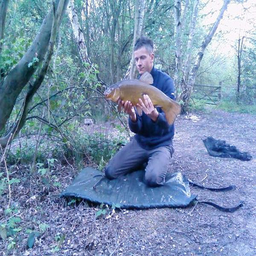

In [8]:
test_lmdb_env = lmdb.open(train_lmdb_file)
test_lmdb_txn = test_lmdb_env.begin()

test_img_path, label = dataset.train[9]
raw = test_lmdb_txn.get(test_img_path.encode())
datum.ParseFromString(raw)
test_img = Image.frombytes('RGB', (256,256), datum.data)
test_img

# Use dataset to access lmdb 

In [1]:
from data import data_manager
from config.config_manager import _C as cfg
from data.build_data import build_image_dataset
cfg.DATASET.NAME = "imagenet"
cfg.DATASET.TRAIN_PATH = "/home/allen.jc.lin/imagenet/"

make sure the 
1. imagenet_256x256_lmdb_train
2. imagenet_256x256_lmdb_val

is under the cfg.DATASET.TRAIN_PATH

In [2]:
dataset = get_img_data(cfg)
train_dataset = build_image_dataset(dataset.train, None, dataset.train_lmdb)
val_dataset = build_image_dataset(dataset.val, None, dataset.val_lmdb)

I0702 09:08:39.604611 21339 data_manager.py:60] Training LMDB is used: /home/allen.jc.lin/imagenet/imagenet_256x256_lmdb_train
I0702 09:08:39.606190 21339 data_manager.py:61] Validation LMDB is used: /home/allen.jc.lin/imagenet/imagenet_256x256_lmdb_val


=> ImageNet loaded
Dataset statistics:
  ------------------------------
  subset   | # class | # images
  ------------------------------
  train    |    1000 |  1281167
  val      |    1000 |    50000
  ------------------------------


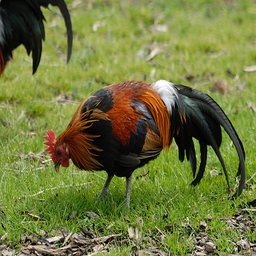

In [6]:
img, label = train_dataset[10050]
img